<a href="https://colab.research.google.com/github/Loinen/geodata_analysis/blob/main/lab2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
# for colab
# ! pip install statsmodels --upgrade

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.ar_model import AutoReg, ar_select_order

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import scipy.stats as scs

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

    TEMP - Mean temperature (.1 Fahrenheit)
    SLP - Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9 (.1 mb)
    WDSP – Mean wind speed (.1 knots)

In [69]:
random.seed(42)
original_data = pd.read_csv("https://raw.githubusercontent.com/Loinen/geodata_analysis/main/data/data_spb.csv", index_col=1, na_values='NA', usecols=['STATION', 'DATE', 'TEMP', 'SLP', 'WDSP'])
original_data

STATION     SLP  TEMP   WDSP
DATE                                        
1990-02-03  26060099999  1010.5  34.3  999.9
1990-02-13  26060099999  1002.7  31.8    5.8
1990-04-29  26060099999  1014.9  50.4    7.8
1990-01-01  26063099999  1020.3  27.5    7.0
1990-01-02  26063099999  1020.4  22.2    3.6
...                 ...     ...   ...    ...
2019-12-31  26072099999   993.5  35.8    5.1
2020-01-01  26063099999  9999.9  33.1    9.1
2020-01-02  26063099999  9999.9  38.7   11.0
2020-01-01  26072099999  1006.7  30.2    3.6
2020-01-02  26072099999  1002.5  37.6    6.6

[13949 rows x 4 columns]

In [70]:
original_data = original_data.loc[original_data.STATION == 26063099999]
original_data = original_data.drop(columns='STATION')

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


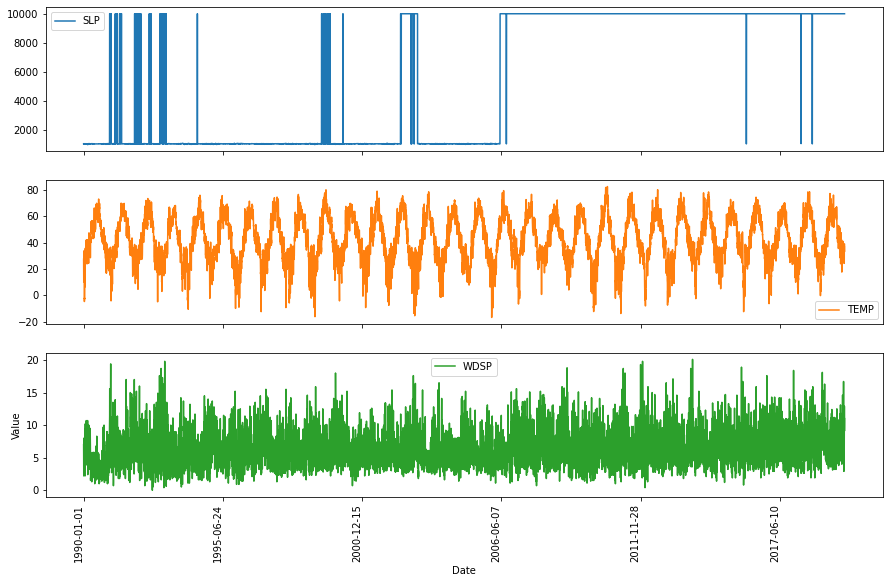

In [71]:
original_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()
# we can see a lot of gaps at the end

In [72]:
# удаление пропущенных значений + убираем все после 2006 года
original_data = original_data.loc[:'2006-01-01']

data = original_data.copy()
missing_vals = data.loc[data.SLP==9999.9]
data = data.replace(9999.9, np.nan, regex=True)
data = data.dropna(subset=['SLP'])

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


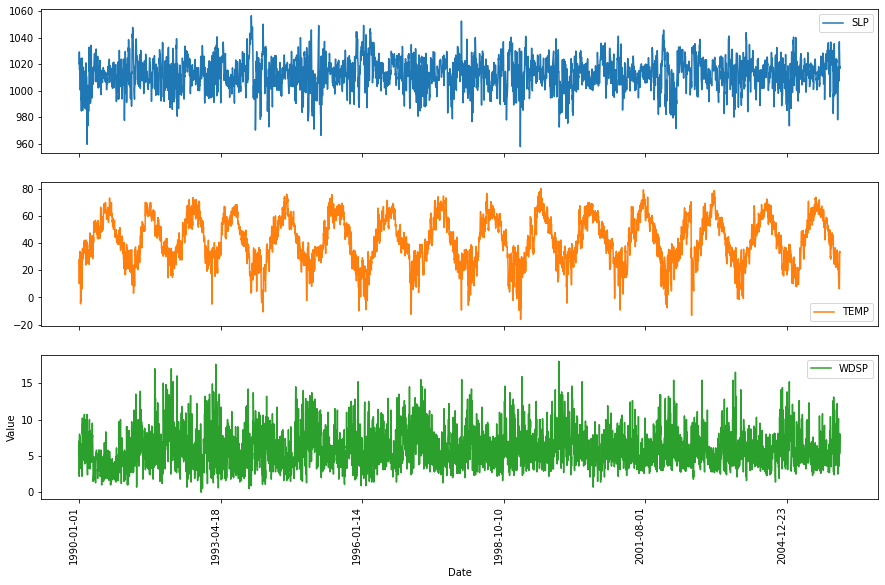

In [73]:
data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [74]:
data.shape

(5375, 3)

In [75]:
missing_vals.shape

(469, 3)

In [76]:
# заполнение медианой
missing_vals['SLP'] = data['SLP'].median()

filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

# Приводим ряд к стационарному

In [77]:
# рисует ряд, автокорреляцию
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
Критерий Дики-Фуллера: p=0.000000


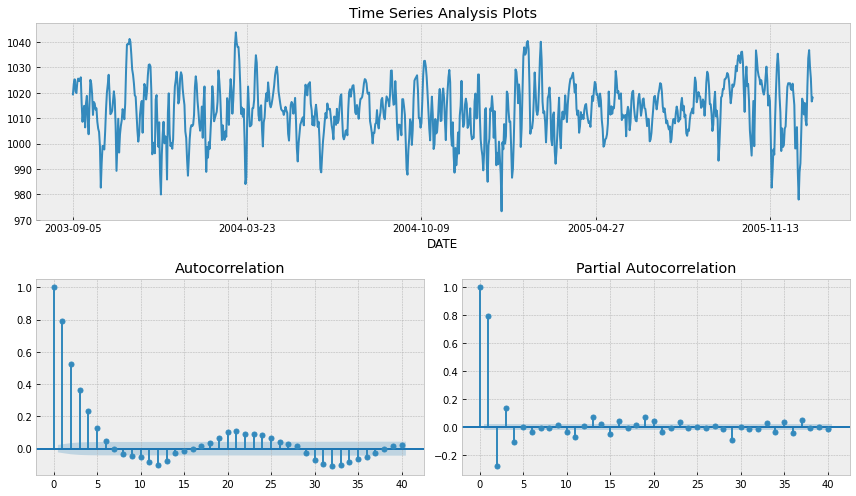

In [78]:
tsplot(filled_data['SLP'][-850:], lags=40)

На автокорреляционной функции сезонность, ее нужно убрать.

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
Критерий Дики-Фуллера: p=0.000000


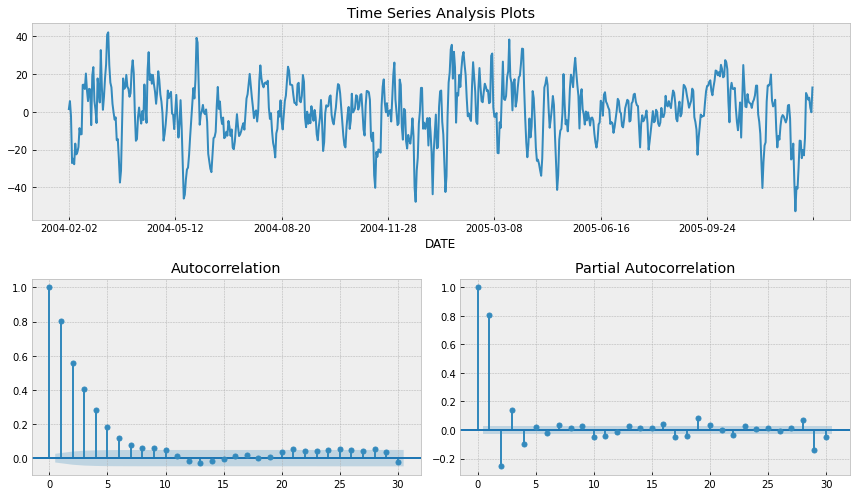

In [79]:
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(24*3)
tsplot(filled_data.SLP[-700:], lags=30)

Еще нужно убрать значимые лаги.

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
Критерий Дики-Фуллера: p=0.000000


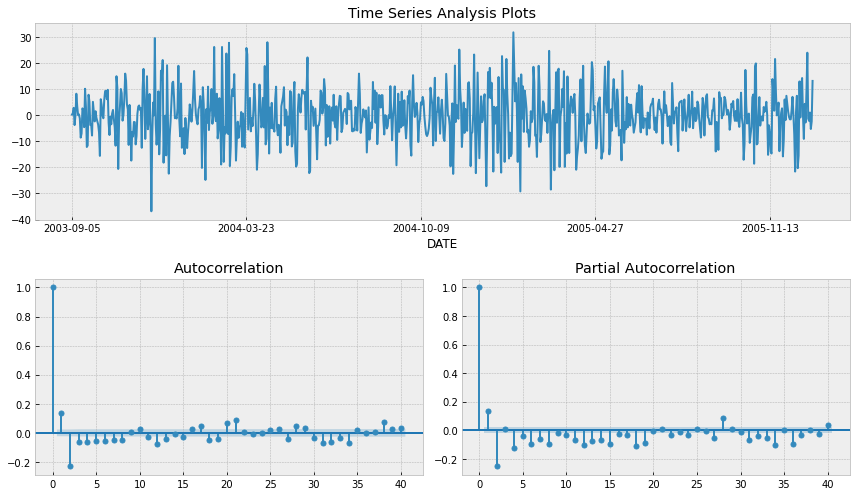

In [80]:
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(1)
tsplot(filled_data.SLP[-850:], lags=40)

Теперь наш ряд стационарный.

# Строим авторегрессию

In [81]:
pressure = filled_data['SLP'].values

In [82]:
def autoreg(series, prediction_size, train_size, lags, trend, exog=None):
    X_train_autoreg, X_test_autoreg = series[len(series)-train_size-prediction_size:len(series)-prediction_size],\
    series[len(series)-prediction_size:]
    
    if exog is None:
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=False)
    else:
        exog_train, exog_test = exog[len(exog)-train_size-prediction_size:len(exog)-prediction_size],\
        exog[len(exog)-prediction_size:]
        
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend, exog=exog_train)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=True, exog_oos=exog_test)
    
    rmse = sqrt(mean_squared_error(X_test_autoreg, predictions))
    mae = mean_absolute_error(X_test_autoreg, predictions)
    
    fig, ax = plt.subplots()

    ax.plot(X_test_autoreg, label="Test")
    ax.plot(predictions, label="Prediction")

    ax.legend()
    plt.show()
    
    print("rmse", rmse)
    print("mae", mae)
    
    return predictions

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


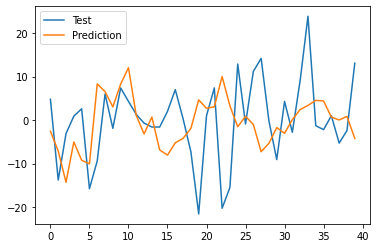

rmse 11.183557262707266
mae 8.575124549584633


In [83]:
prediction_size = 40
predictions_5_points = autoreg(pressure, prediction_size, 50, 16, 'n')

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


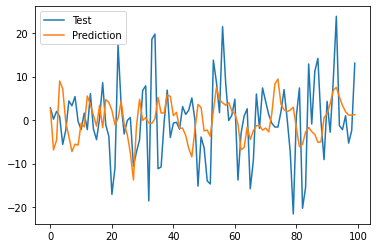

rmse 9.376777592280725
mae 7.599197947622407


In [84]:
prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 100, 35, 'n')

# Добавляем температурный ряд, его тоже надо сделать стационарным

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
Критерий Дики-Фуллера: p=0.493533


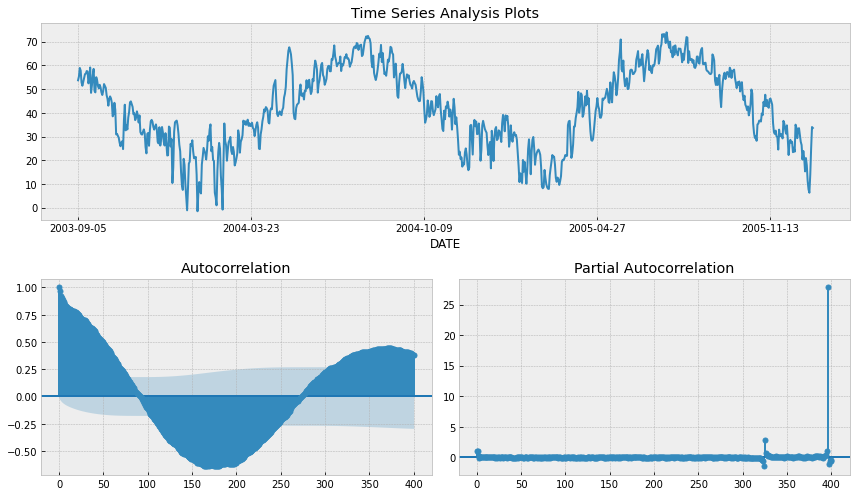

In [85]:
tsplot(filled_data['TEMP'][-850:], lags=400)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
Критерий Дики-Фуллера: p=0.000000


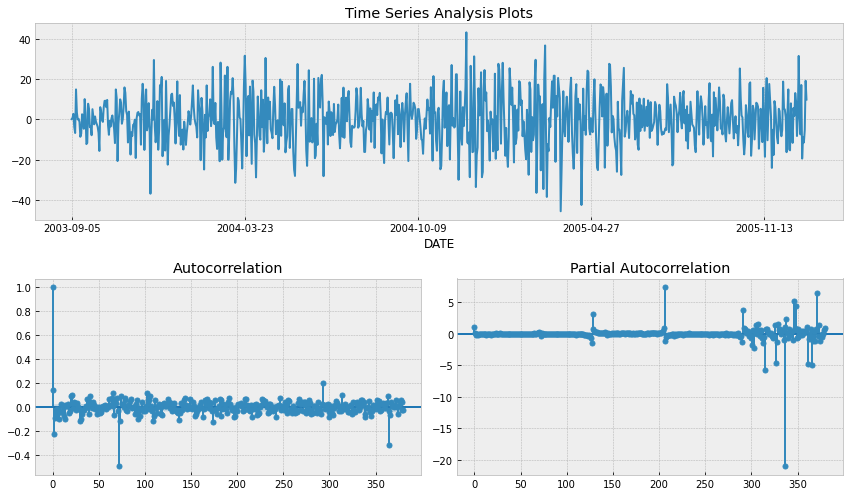

In [86]:
filled_data['TEMP'] = filled_data.SLP - filled_data.SLP.shift(365)
tsplot(filled_data.TEMP[-850:], lags=380)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
Критерий Дики-Фуллера: p=0.000000


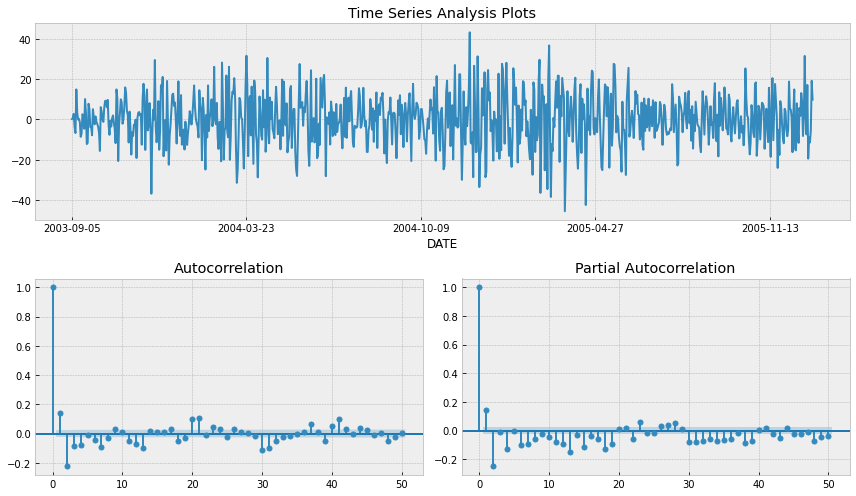

In [87]:
tsplot(filled_data.TEMP[-850:], lags=50)

In [88]:
temp = filled_data['TEMP'].values

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


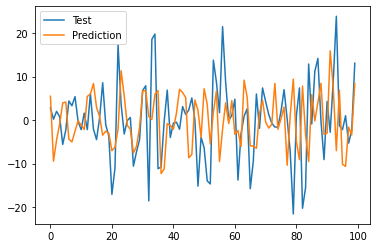

rmse 10.39547564124066
mae 7.899361535361494


In [89]:
prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 100, 29, 'n', exog=temp)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


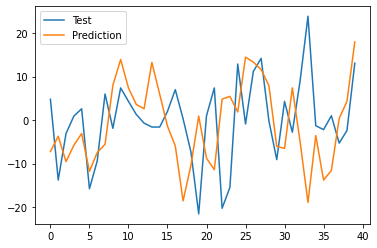

rmse 12.88517894964615
mae 10.144537286445416


In [90]:
prediction_size = 40
predictions_5_points = autoreg(pressure, prediction_size, 40, 10, 'n', exog=temp)

# Вариант с 1 семестра (линейная регрессия)

Mean absolute error =  8.313310354591888
Mean squared error =  113.10300175061428


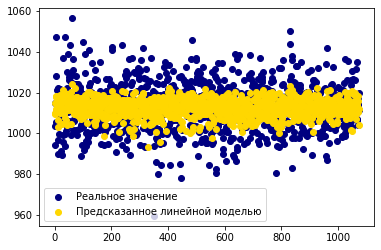

In [91]:
X = data[['WDSP', 'TEMP']]
y = data[['SLP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

model = LinearRegression(normalize=True).fit(X_train,y_train)
predicted_del = model.predict(X_test)
predicted_del

mae = mean_absolute_error(y_test, predicted_del)
mse = mean_squared_error(y_test, predicted_del)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

x = range(len(y_test))
plt.scatter(x, y_test, color='navy', label=u'Реальное значение')
plt.scatter(x, predicted_del, color='gold', label=u'Предсказанное линейной моделью')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


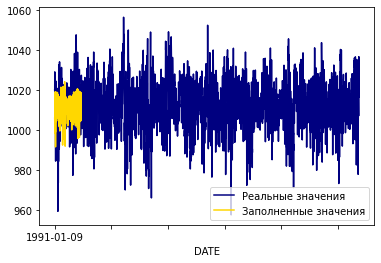

In [92]:
# заполнение пропусков лин регрессией
X_miss = missing_vals[['WDSP', 'TEMP']]
y_pred = model.predict(X_miss)

missing_vals['SLP'] = y_pred

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()

In [93]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


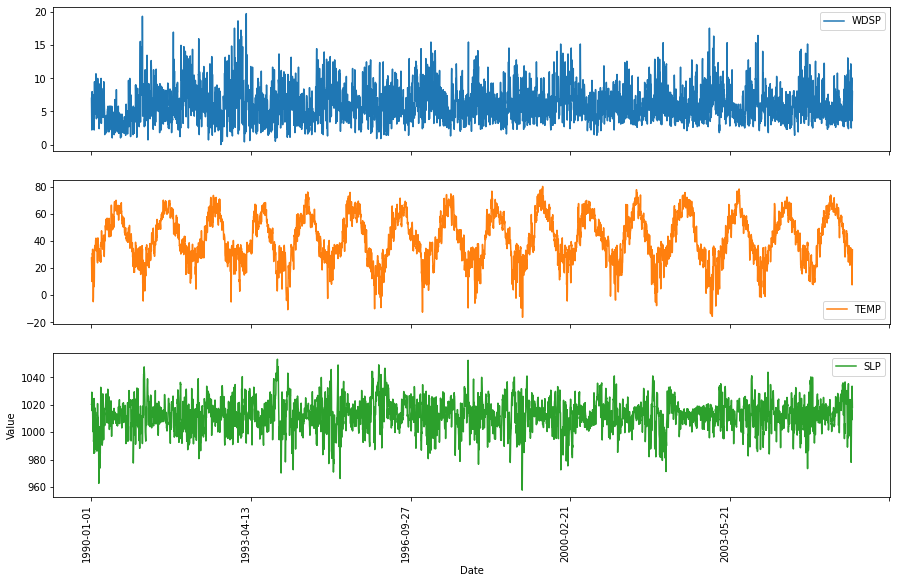

In [94]:
filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [95]:
model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)

In [96]:
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse) 

Mean absolute error =  8.31331035459188
Mean squared error =  113.1030017506141


# Медиана

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


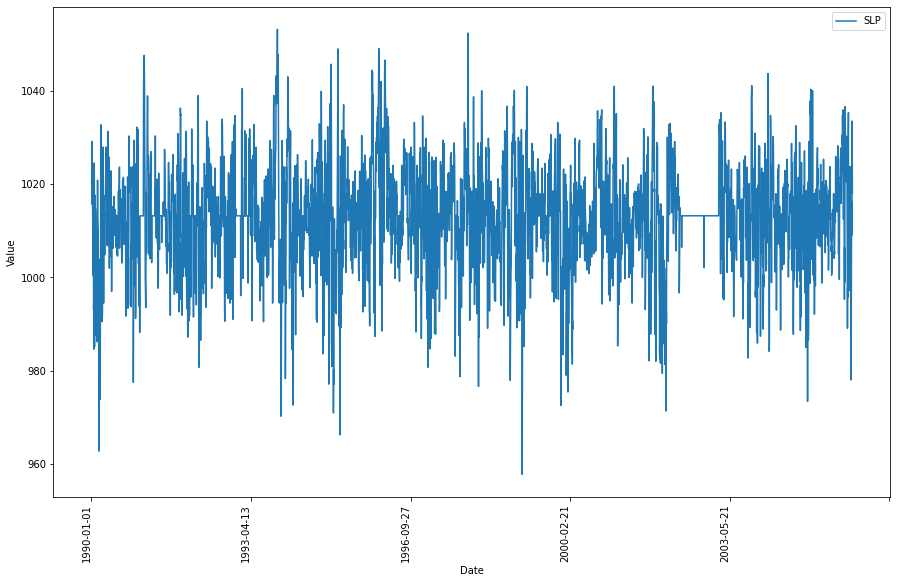

Mean absolute error =  8.293829557237592
Mean squared error =  112.76744765270718


In [97]:
missing_vals['SLP'] = train['SLP'].median()

train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data['SLP'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


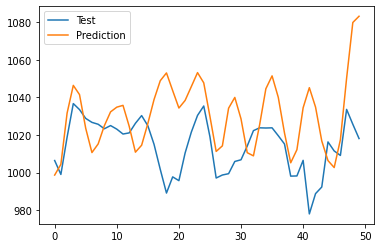

rmse 26.622202424634455
mae 20.55987090006058


In [98]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 40, 'ct')

# Линейная интерполяция (проверка на рандомных пропусках)

100 (500, 3)
C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


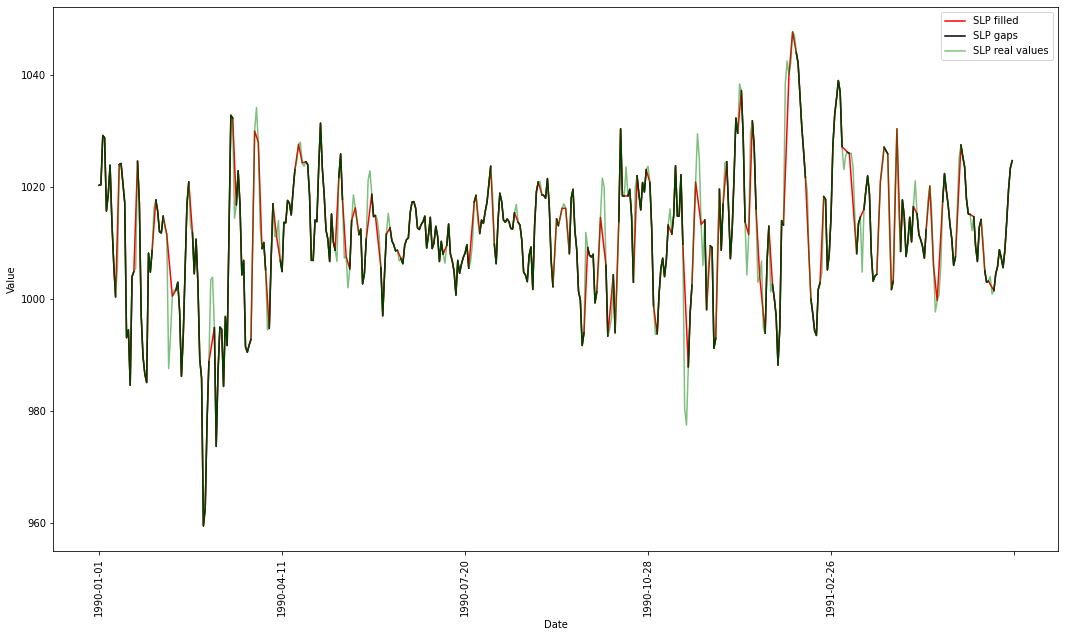

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


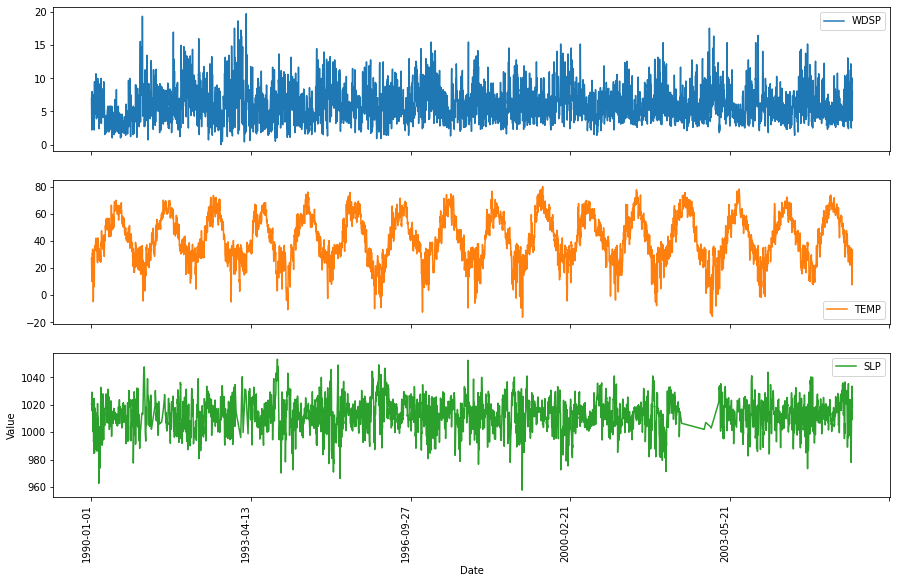

Mean absolute error =  8.300717034195577
Mean squared error =  113.03582283661285


In [99]:
missing_nan = original_data.copy()
missing_nan = missing_nan.replace(9999.9, np.nan, regex=True)

random_missing = data.copy()
random_missing = random_missing[:500]
n_missing = int(random_missing.SLP.size/5) 
print(n_missing, random_missing.shape)
random_idx = np.random.choice(random_missing.index, n_missing, replace=False)
random_missing.at[random_idx, "SLP"] = np.nan
random_missing = random_missing.sort_index()

filled = random_missing.copy()
filled['SLP'] = filled[['SLP']].interpolate(method='linear')['SLP']

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

missing_interpolate = missing_nan[['SLP']].interpolate(method='linear')['SLP']
missing_vals['SLP'] = missing_interpolate

train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


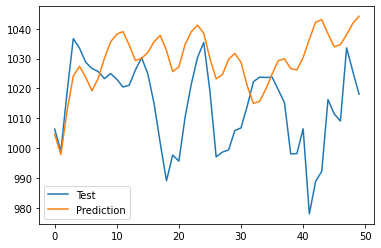

rmse 22.536886899297915
mae 17.71513296473502


In [100]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

# Интерполяция сплайнами

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


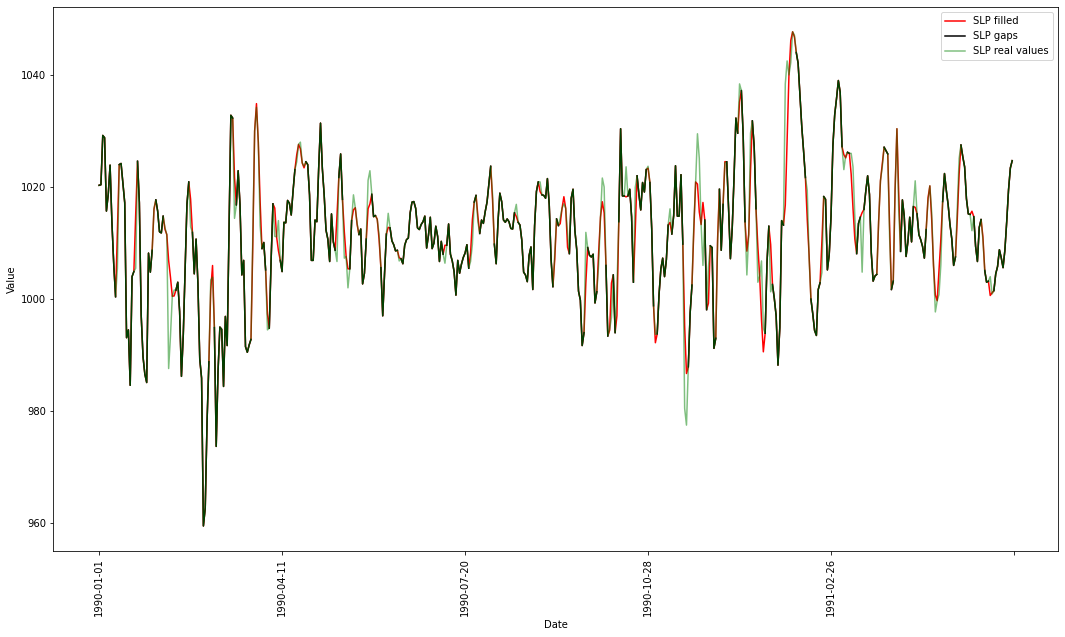

In [101]:
s = pd.Series(random_missing["SLP"].values)
filled['SLP'] = s.interpolate(method='spline', order=3).values

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [102]:
missing_spline = missing_nan.copy()
s = pd.Series(missing_spline["SLP"].values)

missing_spline['SLP'] = s.interpolate(method='spline', order=3).values
missing_vals['SLP'] = missing_spline

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


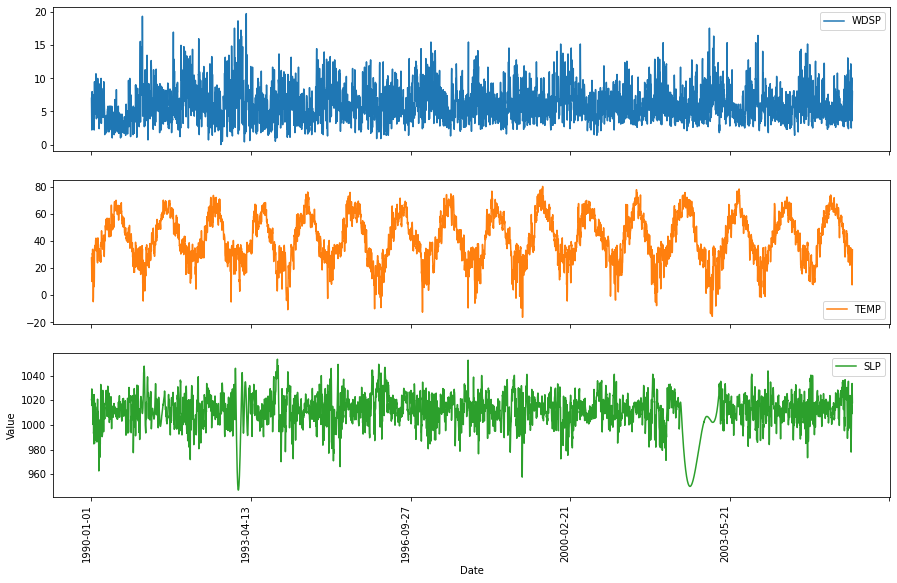

Mean absolute error =  8.490055469025435
Mean squared error =  116.48842739609749


In [103]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


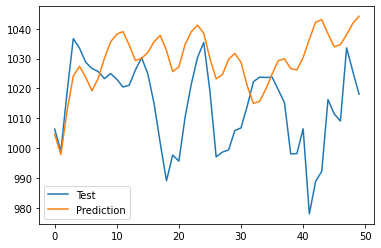

rmse 22.536886899297915
mae 17.71513296473502


In [104]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

<h2>KNN</h2>

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


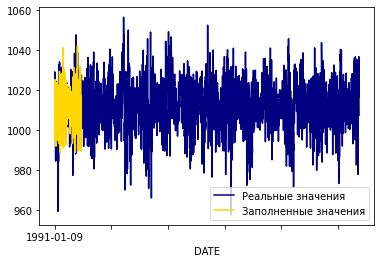

In [105]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

missing_knn = missing_nan.copy()
missing_knn['SLP'] = imputer.fit_transform(missing_knn)
missing_vals['SLP'] = missing_knn

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


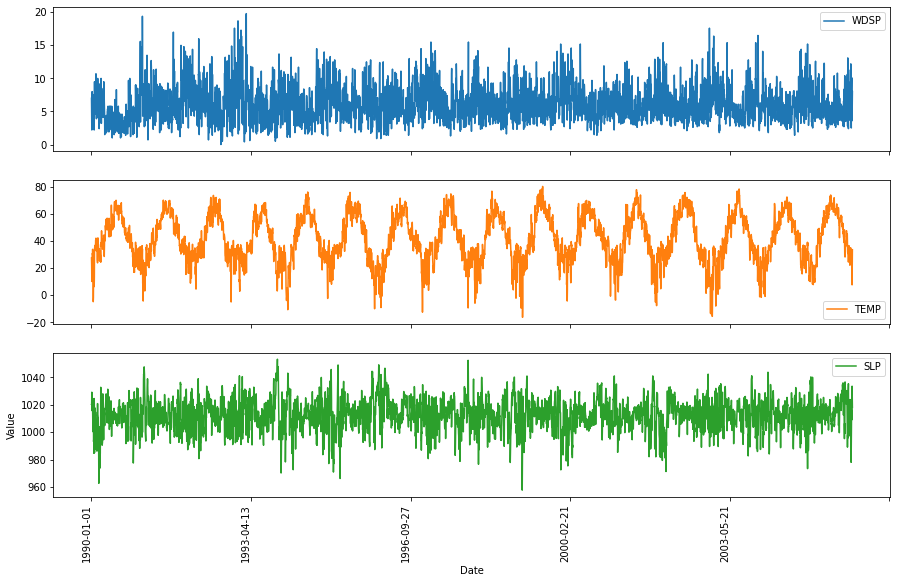

Mean absolute error =  8.307570115479232
Mean squared error =  113.06073974696162


In [106]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_knn = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_knn)
mse = mean_squared_error(y_test, predicted_knn)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


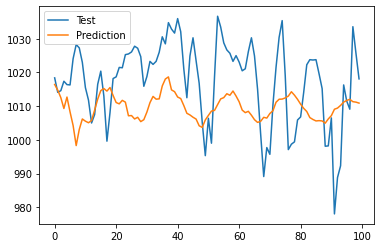

rmse 14.141905113467196
mae 12.273510589702937


In [107]:
# Тут я поменял цифры, чтобы посмотреть, что получится. (Спойлер. Если везде поменять цифры, то везде опять одинаковые результаты)
pressure = filled_data['SLP'].values
prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 150, 40, 'ct')

<h2>Итеративно</h2>

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


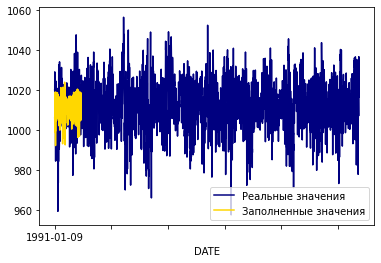

In [108]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

missing_inter = missing_nan.copy()
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data.dropna())

missing_inter['SLP'] = imp_mean.transform(missing_inter)
missing_vals['SLP'] = missing_inter

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


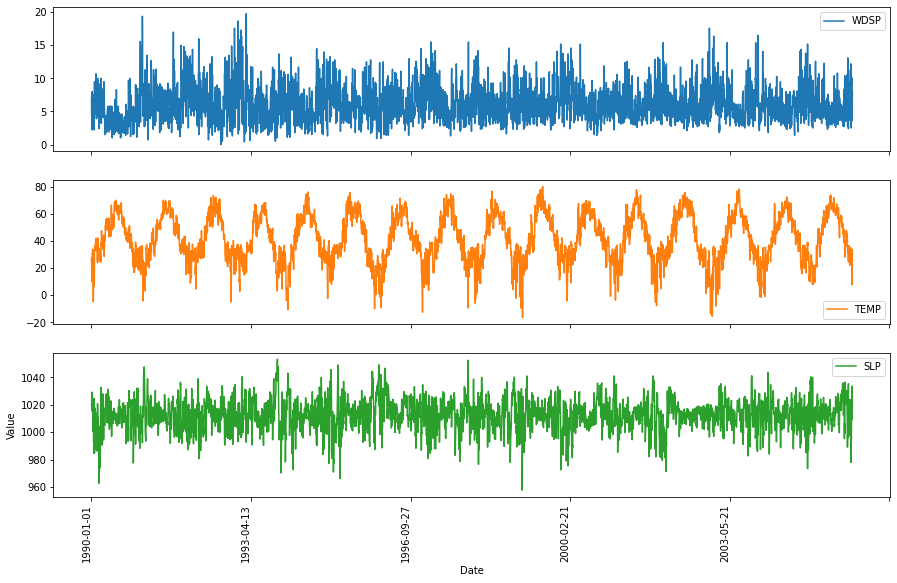

Mean absolute error =  8.312103797466422
Mean squared error =  113.07632241266136


In [109]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


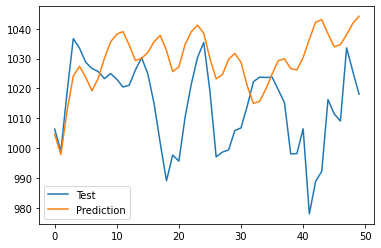

rmse 22.536886899297915
mae 17.71513296473502


In [110]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')



pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


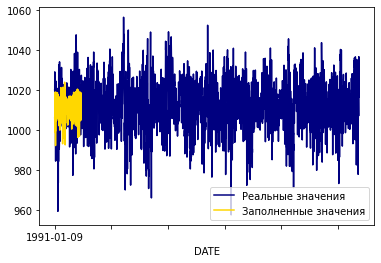

In [111]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

missing_inter = missing_nan.copy()
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data.dropna())

missing_inter['SLP'] = imp_mean.transform(missing_inter)
missing_vals['SLP'] = missing_inter

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


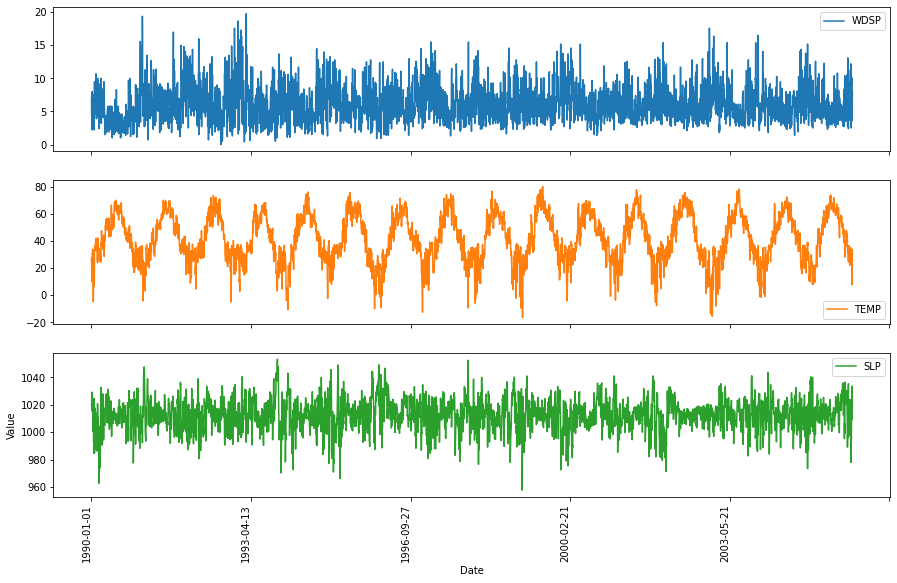

Mean absolute error =  8.312103797466422
Mean squared error =  113.07632241266136


In [112]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


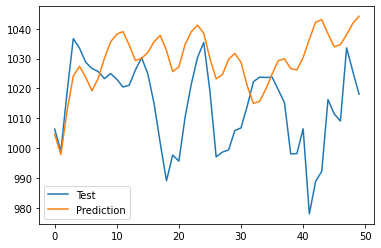

rmse 22.536886899297915
mae 17.71513296473502


In [113]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

<h2>Использование фильтра Савицкого-Голэя</h2>

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


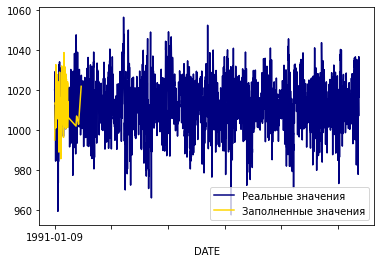

In [114]:
from scipy.signal import savgol_filter

missing_savgol = missing_nan.copy()
s = pd.Series(missing_savgol["SLP"].values)

missing_savgol['SLP'] = savgol_filter(s.interpolate(method='linear', order=1).values,mode='nearest', window_length=7, polyorder=2)
missing_vals['SLP'] = missing_savgol

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


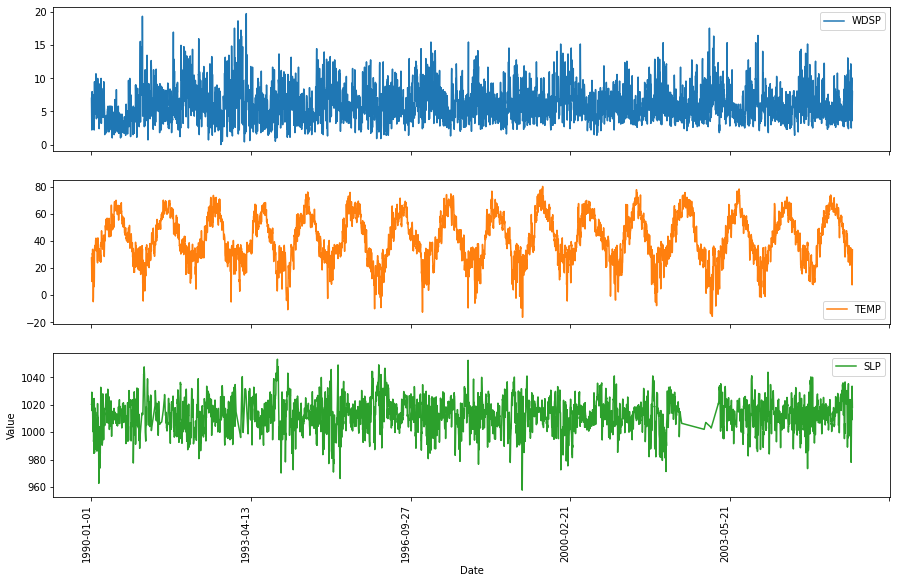

Mean absolute error =  8.300597597315933
Mean squared error =  113.0374650854273


In [115]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


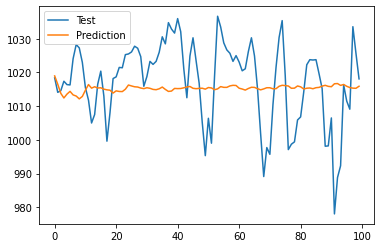

rmse 12.35028234700313
mae 10.201857146163468


In [116]:
pressure = filled_data['SLP'].values

prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 500, 29, 'n', exog=temp)

<h2>Скользящее среднее</h2>

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


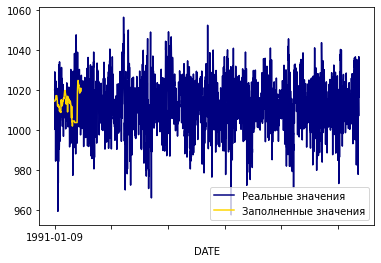

In [138]:
missing_rol = missing_nan.copy()
missing_rol['SLP'] = missing_rol.rolling(min_periods=1, center=True, window=150).mean()
missing_vals['SLP'] = missing_rol

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


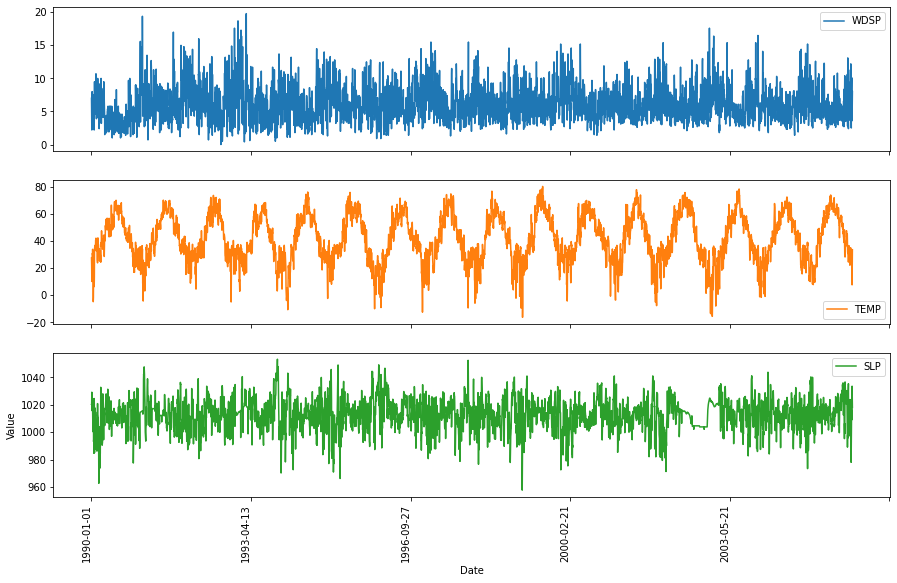

Mean absolute error =  8.302855459380742
Mean squared error =  112.83354761226455


In [139]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


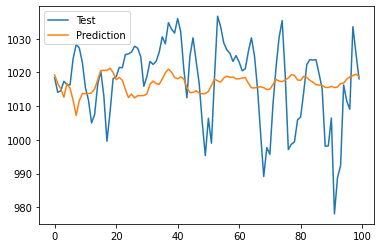

rmse 12.061410465258318
mae 9.675742325278023


In [141]:
pressure = filled_data['SLP'].values

prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 100, 29, 'n', exog=temp)

#lstm

In [48]:
seq_len = 3
n = int(data.SLP.size*0.7)
scaler = MinMaxScaler(feature_range=(0,1))
n_future = 14
n_past = 90 # На основе 3 мес на 2 недели
data2 = data.copy()
data2 = data2.dropna()

data2['SLP'] = data2.SLP - data2.SLP.shift(24*3)
data2['SLP'] = data2.SLP - data2.SLP.shift(1)

train_slp = data2.iloc[100:n,0:1].values
test_slp = data2.iloc[n:n+n_past,0:1].values
test_slp_fut = data2.iloc[n+n_past:n+n_past+n_future,0:1].values

scaled_values = scaler.fit_transform(train_slp)
scaled_values_test = scaler.fit_transform(test_slp)
scaled_values_test = np.array(scaled_values_test)
scaled_values_test = np.reshape(scaled_values_test,(scaled_values_test.shape[1],scaled_values_test.shape[0],1))

In [49]:
x_train = []
y_train = []
for i in range(0,len(scaled_values)-n_past-n_future+1):
    x_train.append(scaled_values[i:i + n_past, 0])
    y_train.append(scaled_values[i + n_past:i + n_past + n_future, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1))

In [50]:
model = Sequential()

model.add(Bidirectional(LSTM(30, return_sequences=True, input_shape=(x_train.shape[1],1))))
model.add(LSTM(30))
model.add(Dense(n_future, activation='linear'))
model.compile(optimizer='adam', loss='mse',metrics=['acc'])
model.fit(x_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
112/112 [==============================] - 33s 42ms/step - loss: 0.0993 - acc: 0.0717
Epoch 2/30
112/112 [==============================] - 5s 45ms/step - loss: 0.0138 - acc: 0.0736
Epoch 3/30
112/112 [==============================] - 5s 46ms/step - loss: 0.0137 - acc: 0.0671
Epoch 4/30
112/112 [==============================] - 5s 45ms/step - loss: 0.0138 - acc: 0.0693
Epoch 5/30
112/112 [==============================] - 5s 47ms/step - loss: 0.0137 - acc: 0.0677
Epoch 6/30
112/112 [==============================] - 5s 42ms/step - loss: 0.0138 - acc: 0.0660
Epoch 7/30
112/112 [==============================] - 5s 47ms/step - loss: 0.0139 - acc: 0.0663
Epoch 8/30
112/112 [==============================] - 5s 44ms/step - loss: 0.0136 - acc: 0.0746
Epoch 9/30
112/112 [==============================] - 5s 46ms/step - loss: 0.0137 - acc: 0.0759
Epoch 10/30
112/112 [==============================] - 5s 45ms/step - loss: 0.0138 - acc: 0.0703
Epoch 11/30
112/112 [=================

In [51]:
predicted = model.predict(scaled_values_test)
predicted = np.reshape(predicted,(predicted.shape[1],predicted.shape[0]))
predicted = scaler.inverse_transform(predicted)

In [52]:
sqrt(mean_squared_error(test_slp_fut, predicted))

7.966194104827332

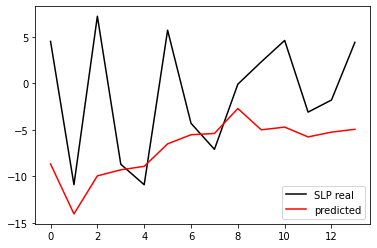

In [53]:
plt.plot(test_slp_fut, 'black', label = 'SLP real')
plt.plot(predicted, 'red', label = 'predicted')
plt.legend()